# École Polytechnique de Montréal
# Département Génie Informatique et Génie Logiciel

# INF8460 – Traitement automatique de la langue naturelle - TP3

# Objectifs d’apprentissage
 • Utiliser des plongements lexicaux pré-entrainés pour de la classification
 
 • Entrainer des plongements lexicaux de type word2vec
 
 • Implanter des modèles de classification neuronaux

## Équipe et contributions 
Veuillez indiquer la contribution effective de chaque membre de l'équipe en pourcentage et en indiquant les modules ou questions sur lesquelles chaque membre a travaillé

Cedric Sadeu (1869737): 1/3

Mamoudou Sacko (1924187): 1/3

Oumayma Messoussi (2016797): 1/3

# Librairies externes

In [13]:
import io
import os
import nltk
import time
import gensim
import sklearn
import zipfile
import requests
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from typing import Dict
from gensim.models import Word2Vec
from keras.models import Sequential
from gensim.test.utils import datapath
from keras.preprocessing import sequence
from collections import Counter, defaultdict
from sklearn.naive_bayes import MultinomialNB
from keras.layers.embeddings import Embedding
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Embedding, LSTM, GRU
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

# Téléchargement et lecture des données

In [15]:
DATA_PATH = os.path.join(os.getcwd(), "aclImdb")

## Téléchargement

In [16]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xzf aclImdb_v1.tar.gz
!rm aclImdb_v1.tar.gz
!echo Done!

--2020-10-26 02:00:05--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  6.89MB/s    in 9.8s    

2020-10-26 02:00:15 (8.18 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]

Done!


In [ ]:
# !wget http://vectors.nlpl.eu/repository/11/3.zip
# !unzip 3.zip
# !rm 3.zip
# !echo Done!

In [17]:
def download_wikipedia_embeddings() -> None:
    if not os.path.exists(os.path.join(os.getcwd(), "model.txt")):
        res = requests.get("http://vectors.nlpl.eu/repository/11/3.zip")
        with zipfile.ZipFile(io.BytesIO(res.content)) as z:
            z.extractall("./")
        os.remove(os.path.join(os.getcwd(), "3.zip"))
        os.remove(os.path.join(os.getcwd(), "meta.json"))
        os.remove(os.path.join(os.getcwd(), "model.bin"))
        os.remove(os.path.join(os.getcwd(), "README"))

## Lecture

In [18]:
def read_data(path):
    traintest = ['train', 'test']
    classes = ['pos', 'neg']
    corpus = {cls: [] for cls in classes}

    # Each data is a list of strings(reviews)
    reviews = []
    labels = []
    for cls in classes:
        dir_path = os.path.join(path, cls)
        
        for filename in os.listdir(dir_path):
            file = os.path.join(dir_path, filename)
            with open(file, encoding = 'utf-8') as f:
                corpus[cls].append(f.read().replace("\n", " "))
        
    return corpus

In [19]:
train_data = read_data(os.path.join(DATA_PATH, 'train'))
test_data = read_data(os.path.join(DATA_PATH, 'test'))

In [20]:
train_data['pos'][0]

'I have the entire Weissmuller Tarzan series on DVD (fully restored editions) & I never tire of watching them. My personal favorite is "Tarzan and His Mate", due entirely (well almost entirely) to Maureen O\'Sullivan\'s costume and the occasional flashes of her genital area beneath that leather flap hanging in front. Before anyone claims that A - It wasn\'t really her, or B - It wasn\'t really what it looks like, let me say that I have watched it numerous time, in high zoom mode, and trust me...it IS her, AND she is completely naked underneath that costume...several times, especially during the lion attack at the end, careful viewing in slow motion and maximum zoom will reveal that she was shaved except for a tiny patch of dark hair covering her labia...There is NO mistake about that at all. As to the swimming scene being a body double in a "skin" suit, yes, it is a double, BUT she is NOT wearing any "skin" suit or anything else...again, slow motion and maximum zoom shows everything to

In [21]:
def create_wikipedia_embeddings(word_indices: Dict[str, int], vocab_len: int) -> np.ndarray:
    with open("./model.txt", "r", encoding="UTF-8") as f:
        shape_string = f.readline()
        lines = f.readlines() 
        
    embedding = np.zeros((vocab_len, 300), dtype=float)
    for line in lines:
        splitted_line = line.split(" ")
        word = splitted_line[0].split("_")[0]
        if word in word_indices and word_indices[word] < vocab_len:
            embedding_line = splitted_line[1:]
            embedding[word_indices[word]] = list(map(float, embedding_line))
        
    return embedding

## Prétraitement

In [22]:
class Preprocess(object):
    def __init__(self, lemmatize=True):
        self.stopwords = set(nltk.corpus.stopwords.words("english"))
        self.lemmatize = lemmatize

    def preprocess_pipeline(self, data):
        clean_tokenized_data = self._clean_doc(data)
        if self.lemmatize:
            clean_tokenized_data = self._lemmatize(clean_tokenized_data)

        return clean_tokenized_data

    def _clean_doc(self, data):
        tokenizer = nltk.tokenize.RegexpTokenizer(r"\w+")
        return [
            [
                token.lower()
                for token in tokenizer.tokenize(review)
                if token.lower() not in self.stopwords
                and len(token) > 1
                and token.isalpha()
                and token != "br]"
            ]
            for review in data
        ]

    def _lemmatize(self, data):
        lemmatizer = nltk.stem.WordNetLemmatizer()
        return [[lemmatizer.lemmatize(word) for word in review] for review in data]

    def convert_to_reviews(self, tokenized_reviews):
        reviews = []
        for tokens in tokenized_reviews:
            reviews.append(" ".join(tokens))

        return reviews

In [23]:
pre = Preprocess()

train_pos = pre.preprocess_pipeline(train_data["pos"])
train_neg = pre.preprocess_pipeline(train_data["neg"])
test_pos = pre.preprocess_pipeline(test_data["pos"])
test_neg = pre.preprocess_pipeline(test_data["neg"])

y_train = [1] * len(train_pos) + [0] * len(train_neg)
y_test = [1] * len(test_pos) + [0] * len(test_neg)
X_train = [" ".join(sentence) for sentence in train_pos + train_neg]
X_test = [" ".join(sentence) for sentence in test_pos + test_neg]

print("{} training sentences: {} pos and {} neg".format(len(X_train), len(train_pos), len(train_neg)))
print("{} test sentences: {} pos and {} neg".format(len(X_test), len(test_pos), len(test_neg)))

25000 training sentences: 12500 pos and 12500 neg
25000 test sentences: 12500 pos and 12500 neg


# 1. Entrainement de plongements lexicaux

Vous devez réaliser les étapes suivantes:

## a) Utiliser Gensim pour entrainer un modèle word2vec sur le corpus. 

In [24]:
X_train_tokenized = [sentence for sentence in train_pos + train_neg]
X_test_tokenized = [sentence for sentence in test_pos + test_neg]

In [25]:
model = Word2Vec(min_count=1, window=5, size=256, alpha=1e-2, min_alpha=1e-4, 
                 workers=(os.cpu_count()*2 - 1), sample=0.01, negative=5)

v = model.build_vocab(X_train_tokenized)

start = time.time()
model.train(X_train_tokenized, total_examples=model.corpus_count, epochs=10)
end = time.time() - start

## b) Décrire les paramètres du ou des modèles entraînés, leur taille sur disque, le nombre de mots encodés, le temps d'entraînement, etc.

In [26]:
print("- Temps d'entrainement (en secondes): %f\n" % end)
print("- Taille du modele sur disque (en octets): ", model.estimate_memory())

word_vectors = model.wv
print("\n- Nombre de mots encodés (= taille du vocab): %d\n" % len(word_vectors.vectors))

- Temps d'entrainement (en secondes): 62.765754

- Taille du modele sur disque (en octets):  {'vocab': 32849500, 'vectors': 67275776, 'syn1neg': 67275776, 'total': 167401052}

- Nombre de mots encodés (= taille du vocab): 65699



**Les parametres du modele word2vec**

*   ***size*** = la taille/nombre de dimensions des vecteurs de plongements générés par le modele. (idealement entre quelques dizaines a quelques centaines). Pour notre modele, on a choisit une valeur multiple de 2 pour une meuilleure gestion de memoire. De plus, les vecteurs de plongements finaux seront de taille (N, 256) avec N la taille du vocabulaire. Ainsi, on a jugé que 256 est un bon compromis.

*   ***min_count*** = la fréquence minimale des mots a considerer. Le modele ignore tous les mots du corpus dont la fréquence est inférieure a *min_count*. On a fixé cette valeur a 1 pour pouvoir construire le vocabulaire le plus large possible qui contient tous les types du corpus.

*   ***window*** = la taille de la fenetre a considerer autour du mot en question (entre le mot cible et ces voisins). (en generale entre 2 et 10). on a utiliser la valeur 5 comme juste milieu de l'intervalle recommendé.

*   ***sample*** =  le seuil de sous-echantillonnage aléatoire des mots les plus fréquents. (idealement entre 0, 1e-5). 

*   ***alpha*** = le taux d'apprentissage. Ce parametre doit etre assez petit pour pouvoir s'approcher le plus de l'optimum local, mais assez grand pour eviter le surapprentissage. Pour cela, on l'a fixé a 0.01.

*   ***min_alpha*** = la valeur a laquelle le taux d'apprentissage *alpha* va diminuer lineairement lors de l'entrainement. Une bonne estimation: alpha - (min_alpha * epochs) ~ 0.00. Dans notre cas, nos valeurs choisies respectent bien cette equation: 0.01 - 0.0001 * 10 = 0.009.

*   ***negative*** = si positive, la valeur indique le nombre de mots "bruit" a introduire. (generalement entre 5 et 20). Ce parametre permet, entre autre, d'eviter le surapprentissage. Apres plusieurs tests, on a gardé la valeur 5.

*   ***workers*** = nombre de threads a utiliser pour l'entrainement. Puisqu'on a utilisé Google Colab, les ressources alloués par session varient, donc pour s'assurer qu'on utilise le maximum de threads disponibles, on recupere ce nombre a travers *os.cpu_count()*.

## c) Décrire le cas échéant et de manière précise tout problème que vous avez eu à obtenir votre modèle et les façons de résoudre ces problèmes.

*   le parametre *sample*: Ce parametre est par excellence le plus sensible. On a du experimenté avec plusieurs valeurs pour etudier son impact et aboutir a de bons resultats.

## d) Retrouvez les 5 mots voisins des mots suivants : excellent, terrible

In [ ]:
print(word_vectors.most_similar('excellent')[:5])
print(word_vectors.most_similar('terrible')[:5])

[('outstanding', 0.9303454160690308), ('fine', 0.9233697652816772), ('fantastic', 0.9128841757774353), ('superb', 0.9098476767539978), ('terrific', 0.9031731486320496)]
[('horrible', 0.969161331653595), ('awful', 0.9571821093559265), ('sucked', 0.8428488373756409), ('suck', 0.8414132595062256), ('atrocious', 0.8380038738250732)]


In [ ]:
# a couple more test cases

print(word_vectors.most_similar('fun')[:5])
print(word_vectors.most_similar('film')[:5])
print(word_vectors.most_similar('acting')[:5])

[('laugh', 0.8044959306716919), ('enjoy', 0.7619494199752808), ('entertaining', 0.7608088254928589), ('enjoyable', 0.7471777200698853), ('scary', 0.7180044054985046)]
[('cinema', 0.7275949716567993), ('documentary', 0.7242180109024048), ('movie', 0.7091220617294312), ('picture', 0.6993308663368225), ('flick', 0.6633319854736328)]
[('writing', 0.784990668296814), ('directing', 0.7593839168548584), ('casting', 0.7466240525245667), ('direction', 0.7362791299819946), ('script', 0.7313761711120605)]


# 2. Classification avec des plongements lexicaux

On vous demande d’effectuer de la classification avec les plongements lexicaux obtenus.

## a) En reprenant le code développé dans le TP1 avec Scikitlearn, on vous demande cette fois de tester un modèle Naïve Bayes et de régression logistique avec des n-grammes (n=1,2,3 ensemble). Essayez de voir si une réduction de dimension améliore la classification. Ne fournissez que votre meilleur modèle. Evaluez vos algorithmes selon les métriques d’accuracy générale et de F1 par classe sur l’ensemble de test.

D'apres nos experiences, la reduction de dimensions n'ameliore pas la performance de nos classificateur. (voir resultats dessous)

**Sans reduction de dimensions**

In [70]:
def buildVocab(X) -> object:
  vectorizer = CountVectorizer(min_df=0, lowercase=False)
  vectorizer.fit(X)
  return vectorizer.vocabulary_

vocab = buildVocab(X_train)

In [71]:
vectorizer = TfidfVectorizer(ngram_range=(1,3), vocabulary=vocab) # max_features=50000

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print('X_train_tfidf:', X_train_tfidf.shape)
print('X_test_tfidf:', X_test_tfidf.shape)

X_train_tfidf: (25000, 65677)
X_test_tfidf: (25000, 65677)


**Naive Bayes (sans reduction de dimensions)**


In [72]:
model = MultinomialNB(alpha=0.6)

start = time.time()

model.fit(X_train_tfidf, y_train)

end = time.time() - start
print("- Temps d'entrainement (en secondes): %f\n" % end)

y_pred = model.predict(X_test_tfidf)

print("Classification report:\n")
print(classification_report(y_test, y_pred, target_names=["N", "P"]))
print("\nAccuracy generale: %f \n" % accuracy_score(y_test, y_pred))

# plot_confusion_matrix(model, X_test_tfidf, y_test, display_labels=["N", "P"], cmap=plt.cm.Blues)
# plt.show()

- Temps d'entrainement (en secondes): 0.031578

Classification report:

              precision    recall  f1-score   support

           N       0.80      0.87      0.84     12500
           P       0.86      0.78      0.82     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000


Accuracy generale: 0.827320 



**Regression logistique (sans reduction de dimensions)**



In [73]:
model = LogisticRegression(C=2.0)

start = time.time()

model.fit(X_train_tfidf, y_train)

end = time.time() - start
print("- Temps d'entrainement (en secondes): %f\n" % end)

y_pred = model.predict(X_test_tfidf)

print("Classification report:\n")
print(classification_report(y_test, y_pred, target_names=["N", "P"]))
print("\nAccuracy generale: %f \n" % accuracy_score(y_test, y_pred))

# plot_confusion_matrix(model, X_test_tfidf, y_test, display_labels=["N", "P"], cmap=plt.cm.Blues)
# plt.show()

- Temps d'entrainement (en secondes): 2.024921

Classification report:

              precision    recall  f1-score   support

           N       0.88      0.88      0.88     12500
           P       0.88      0.87      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000


Accuracy generale: 0.879600 



**Avec reduction de dimensions**


In [74]:
selector = SelectKBest(f_classif, k=100)
selector.fit(X_train_tfidf, y_train)
X_train_r = selector.transform(X_train_tfidf)
X_test_r = selector.transform(X_test_tfidf)

print('X_train_r:', X_train_r.shape)
print('X_test_r:', X_test_r.shape)

X_train_r: (25000, 100)
X_test_r: (25000, 100)


In [19]:
# selector = TruncatedSVD(n_components=100)
# selector.fit(X_train_tfidf, y_train)
# X_train_r = selector.transform(X_train_tfidf)
# X_test_r = selector.transform(X_test_tfidf)

# print('X_train_r:', X_train_r.shape)
# print('X_test_r:', X_test_r.shape)

X_train_r: (25000, 100)
X_test_r: (25000, 100)


**Naive Bayes (avec reduction de dimensions)**


In [75]:
model = MultinomialNB(alpha=0.6)

start = time.time()

model.fit(X_train_r, y_train)

end = time.time() - start
print("- Temps d'entrainement (en secondes): %f\n" % end)

y_pred = model.predict(X_test_r)

print("Classification report:\n")
print(classification_report(y_test, y_pred, target_names=["N", "P"]))
print("\nAccuracy generale: %f \n" % accuracy_score(y_test, y_pred))

# plot_confusion_matrix(model, X_test_tfidf, y_test, display_labels=["N", "P"], cmap=plt.cm.Blues)
# plt.show()

- Temps d'entrainement (en secondes): 0.010054

Classification report:

              precision    recall  f1-score   support

           N       0.82      0.82      0.82     12500
           P       0.82      0.82      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000


Accuracy generale: 0.820240 



**Regression logistique (avec reduction de dimensions)**

In [76]:
model = LogisticRegression(C=2.0)

start = time.time()

model.fit(X_train_r, y_train)

end = time.time() - start
print("- Temps d'entrainement (en secondes): %f\n" % end)

y_pred = model.predict(X_test_r)

print("Classification report:\n")
print(classification_report(y_test, y_pred, target_names=["N", "P"]))
print("\nAccuracy generale: %f \n" % accuracy_score(y_test, y_pred))

# plot_confusion_matrix(model, X_test_tfidf, y_test, display_labels=["N", "P"], cmap=plt.cm.Blues)
# plt.show()

- Temps d'entrainement (en secondes): 0.302186

Classification report:

              precision    recall  f1-score   support

           N       0.85      0.80      0.82     12500
           P       0.81      0.86      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000


Accuracy generale: 0.827760 



## b) En utilisant Tensorflow (ou Pytorch), on vous demande de développer un classificateur perceptron multicouches et un bi-LSTM avec les vecteurs d’un modèle word2vec pré-entrainé sur Wikipédia en Anglais (enwiki_upos_skipgram_300_3_2019) disponible à http://vectors.nlpl.eu/repository/11/3.zip. 

On s’attend à ce que vous effectuiez une moyenne des vecteurs de mots de chaque document pour obtenir un plongement du document.  

Evaluez vos algorithmes selon les métriques d’accuracy générale et de F1 par classe sur l’ensemble de test. Pour chacun des modèles, indiquez ses performances et ses spécifications (nombre d’époques, régularisation, optimiseur, nombre de couches, etc.). N’hésitez pas à expérimenter avec différents paramètres. Vous ne devez reporter que votre meilleure expérimentation.

In [ ]:
y_train = [1] * len(train_pos) + [0] * len(train_neg)
y_test = [1] * len(test_pos) + [0] * len(test_neg)
X_train = [" ".join(sentence) for sentence in train_pos + train_neg]
X_test = [" ".join(sentence) for sentence in test_pos + test_neg]

In [30]:
def buildVocab(X) -> object:
  vectorizer = CountVectorizer(min_df=0, lowercase=False)
  vectorizer.fit(X)
  return vectorizer.vocabulary_

vocab = buildVocab(X_train)
embeddings = create_wikipedia_embeddings(vocab, len(vocab))

print(embeddings.shape)
print(len(vocab))

(65677, 300)
65677


In [32]:
def get_X_and_y_embedded(X, y, vocab, embeddings, feature) -> object:
  X_embedded = np.zeros((len(X), feature), dtype=float)
  y_embedded = np.zeros((len(y), 1), dtype=int)

  for i, doc in enumerate(X):
    vec = np.zeros((1, feature), dtype=float)
    tokens = doc.split()
    cpt = 0
    for word in tokens:
      if(word in vocab):
        cpt += 1
        vec += embeddings[vocab[word]]
    vec /= cpt
    X_embedded[i] = vec
    y_embedded[i] = y[i]

  return X_embedded, y_embedded

X_train_wiki, y_train_wiki = get_X_and_y_embedded(X_train, y_train, vocab, embeddings, 300)
X_test_wiki, y_test_wiki = get_X_and_y_embedded(X_test, y_test, vocab, embeddings, 300)

print(X_train_wiki.shape)
print(y_train_wiki.shape)
print(X_test_wiki.shape)
print(y_test_wiki.shape)

(25000, 300)
(25000, 1)
(25000, 300)
(25000, 1)


**MLP model**

In [77]:
X_t, X_v, y_t, y_v = train_test_split(X_train_wiki, y_train_wiki, test_size=0.1)

mlp_wiki = tf.keras.Sequential([
tf.keras.layers.Dense(600, input_shape=(300,), activation="relu"),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.Dense(1, activation="sigmoid")
])

adam = tf.keras.optimizers.Adam(learning_rate=0.001)

mlp_wiki.compile(
optimizer=adam,
loss="mean_squared_error",
metrics=["accuracy"]
)

start = time.time()

mlp_wiki_h = mlp_wiki.fit(X_t, y_t,
epochs=50,
batch_size=500,
validation_data=(X_v, y_v))

end = time.time() - start
print("- Temps d'entrainement (en secondes): %f\n" % end)

Epoch 1/50
45/45 [==============================] - 0s 4ms/step - loss: 0.2374 - accuracy: 0.6814 - val_loss: 0.2189 - val_accuracy: 0.7576
Epoch 2/50
45/45 [==============================] - 0s 2ms/step - loss: 0.1969 - accuracy: 0.7611 - val_loss: 0.1776 - val_accuracy: 0.7672
Epoch 3/50
45/45 [==============================] - 0s 2ms/step - loss: 0.1674 - accuracy: 0.7748 - val_loss: 0.1610 - val_accuracy: 0.7708
Epoch 4/50
45/45 [==============================] - 0s 2ms/step - loss: 0.1544 - accuracy: 0.7880 - val_loss: 0.1514 - val_accuracy: 0.7864
Epoch 5/50
45/45 [==============================] - 0s 2ms/step - loss: 0.1470 - accuracy: 0.7996 - val_loss: 0.1464 - val_accuracy: 0.7944
Epoch 6/50
45/45 [==============================] - 0s 2ms/step - loss: 0.1419 - accuracy: 0.8043 - val_loss: 0.1413 - val_accuracy: 0.8004
Epoch 7/50
45/45 [==============================] - 0s 2ms/step - loss: 0.1383 - accuracy: 0.8103 - val_loss: 0.1410 - val_accuracy: 0.8036
Epoch 8/50
45/45 [==

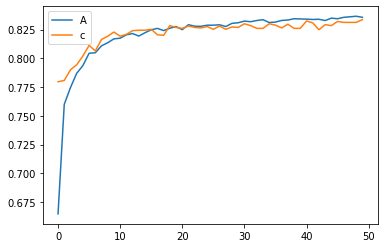

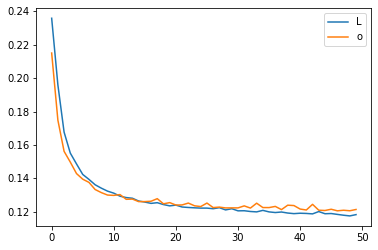

In [35]:
plt.plot(mlp_wiki_h.history['accuracy'], label="Training set")
plt.plot(mlp_wiki_h.history['val_accuracy'], label="Validation set")
plt.legend("Accuracy")
plt.show()

plt.plot(mlp_wiki_h.history['loss'], label="Training set")
plt.plot(mlp_wiki_h.history['val_loss'], label="Validation set")
plt.legend("Loss")
plt.show()

In [37]:
loss, acc = mlp_wiki.evaluate(X_test_wiki, y_test_wiki)
# y_pred = model1.predict(X_test_wiki)
print('Test Accuracy: %f' % (acc*100))

782/782 [==============================] - 1s 2ms/step - loss: 0.1236 - accuracy: 0.8239
Test Accuracy: 82.392001


**LSTM model**

In [38]:
def fromTextToFrequenceWiki(corpus, vocab):
  result = []
  for doc in corpus:
    doc_index = []
    for token in doc.split():
      if(token in vocab):
        doc_index.append(vocab[token])
    result.append(doc_index)
  return result

def getMedian(corpus):
  total_lenght = sorted([len(doc) for doc in corpus])
  return total_lenght[int(len(total_lenght) * 2/3)]

y_train_lstm = [1] * len(train_pos) + [0] * len(train_neg)
y_test_lstm = [1] * len(test_pos) + [0] * len(test_neg)
X_train_lstm = [" ".join(sentence) for sentence in train_pos + train_neg]
X_test_lstm = [" ".join(sentence) for sentence in test_pos + test_neg]

y_train_lstm = np.array(y_train_lstm)
y_test_lstm = np.array(y_test_lstm)

tokenizer = tf.keras.preprocessing.text.Tokenizer(split=' ', filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(X_train_lstm)
vocab_lstm = tokenizer.word_index

X_train_lstm_sequences = fromTextToFrequenceWiki(X_train_lstm, vocab_lstm)
sequence_len = getMedian(X_train_lstm_sequences)
X_train_lstm_pad = tf.keras.preprocessing.sequence.pad_sequences( X_train_lstm_sequences, maxlen=sequence_len, dtype='int32', padding='pre', truncating='pre',value=0.0)

embeddings_lstm = create_wikipedia_embeddings(vocab_lstm, len(vocab_lstm))

print(X_train_lstm_pad.shape)
print(y_train_lstm.shape)
print(embeddings_lstm.shape)

(25000, 124)
(25000,)
(65699, 300)


In [78]:
features = 300

lstm_model_wiki = tf.keras.Sequential([
    Embedding(len(embeddings_lstm), features, input_length=sequence_len, embeddings_initializer=tf.keras.initializers.Constant(embeddings_lstm), trainable=False),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(LSTM(128, input_shape=(sequence_len, features))),
    tf.keras.layers.Dense(1, activation="sigmoid") 
])

X_t, X_v, y_t, y_v = train_test_split(X_train_lstm_pad, y_train_lstm, test_size=0.1)

lstm_model_wiki.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

start = time.time()

lstm_model_wiki_h = lstm_model_wiki.fit(X_t, y_t,
epochs=10,
batch_size=300, 
validation_data=(X_v, y_v))

end = time.time() - start
print("- Temps d'entrainement (en secondes): %f\n" % end)

Epoch 1/10
75/75 [==============================] - 5s 70ms/step - loss: 0.5493 - accuracy: 0.7340 - val_loss: 0.4521 - val_accuracy: 0.7992
Epoch 2/10
75/75 [==============================] - 5s 60ms/step - loss: 0.4533 - accuracy: 0.7926 - val_loss: 0.4357 - val_accuracy: 0.8096
Epoch 3/10
75/75 [==============================] - 5s 61ms/step - loss: 0.4322 - accuracy: 0.8057 - val_loss: 0.4088 - val_accuracy: 0.8208
Epoch 4/10
75/75 [==============================] - 5s 61ms/step - loss: 0.4153 - accuracy: 0.8158 - val_loss: 0.4169 - val_accuracy: 0.8204
Epoch 5/10
75/75 [==============================] - 5s 61ms/step - loss: 0.3958 - accuracy: 0.8257 - val_loss: 0.3925 - val_accuracy: 0.8248
Epoch 6/10
75/75 [==============================] - 5s 61ms/step - loss: 0.3869 - accuracy: 0.8280 - val_loss: 0.3784 - val_accuracy: 0.8304
Epoch 7/10
75/75 [==============================] - 5s 61ms/step - loss: 0.3731 - accuracy: 0.8333 - val_loss: 0.4082 - val_accuracy: 0.8220
Epoch 8/10
75

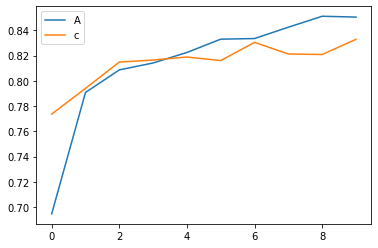

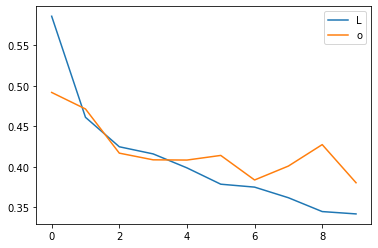

In [53]:
plt.plot(lstm_model_wiki_h.history['accuracy'], label="Training set")
plt.plot(lstm_model_wiki_h.history['val_accuracy'], label="Validation set")
plt.legend("Accuracy")
plt.show()

plt.plot(lstm_model_wiki_h.history['loss'], label="Training set")
plt.plot(lstm_model_wiki_h.history['val_loss'], label="Validation set")
plt.legend("Loss")
plt.show()

In [54]:
# tokenizer = tf.keras.preprocessing.text.Tokenizer(split=' ', filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
# tokenizer.fit_on_texts(X_test_lstm)
# vocab_lstm = tokenizer.word_index

X_test_lstm_sequences = fromTextToFrequenceWiki(X_test_lstm, vocab_lstm)
X_test_lstm_pad = tf.keras.preprocessing.sequence.pad_sequences( X_test_lstm_sequences, maxlen=sequence_len, dtype='int32', padding='pre', truncating='pre',value=0.0)

loss, acc = lstm_model_wiki.evaluate(X_test_lstm_pad, y_test_lstm)
print('Test Accuracy: %f' % (acc*100))

782/782 [==============================] - 6s 8ms/step - loss: 0.3599 - accuracy: 0.8432
Test Accuracy: 84.320003


## c) Ré-entrainez les modèles en b) avec vos propres vecteurs. Comparez maintenant la performance obtenue en b) avec celles que vous obtenez en utilisant vos propres vecteurs de mots entrainés sur le corpus. 

**MLP model**

In [62]:
def get_X_and_y_embedded(X, y, vocab, embeddings, feature) -> object:
  X_embedded = np.zeros((len(X), feature), dtype=float)
  y_embedded = np.zeros((len(y), 1), dtype=int)

  for i, doc in enumerate(X):
    vec = np.zeros((1, feature), dtype=float)
    tokens = doc.split()
    cpt = 0
    for word in tokens:
      if(word in vocab):
        cpt += 1
        vec += embeddings[word]
    vec /= cpt
    X_embedded[i] = vec
    y_embedded[i] = y[i]

  return X_embedded, y_embedded

X_wv, y_wv = get_X_and_y_embedded(X_train, y_train, vocab, word_vectors, 256)
X_test_wv, y_test_wv = get_X_and_y_embedded(X_test, y_test, vocab, word_vectors, 256)

In [79]:
X_wv_t, X_wv_v, y_wv_t, y_wv_v = train_test_split(X_wv,
y_wv, test_size=0.1)

mlp_wv = tf.keras.Sequential([
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(600, input_shape=(256,), activation="relu"),
tf.keras.layers.Dense(1, activation="sigmoid")
])

mlp_wv.compile(
optimizer="adam",
loss="mean_squared_error",
metrics=["accuracy"]
)

start = time.time()

mlp_wv_h = mlp_wv.fit(X_wv_t, y_wv_t,
epochs=30,
batch_size=300,
validation_data=(X_wv_v, y_wv_v))

end = time.time() - start
print("- Temps d'entrainement (en secondes): %f\n" % end)

Epoch 1/30
75/75 [==============================] - 0s 3ms/step - loss: 0.2050 - accuracy: 0.6800 - val_loss: 0.1824 - val_accuracy: 0.7220
Epoch 2/30
75/75 [==============================] - 0s 2ms/step - loss: 0.1916 - accuracy: 0.7068 - val_loss: 0.1655 - val_accuracy: 0.7704
Epoch 3/30
75/75 [==============================] - 0s 2ms/step - loss: 0.1903 - accuracy: 0.7113 - val_loss: 0.1758 - val_accuracy: 0.7404
Epoch 4/30
75/75 [==============================] - 0s 2ms/step - loss: 0.1893 - accuracy: 0.7130 - val_loss: 0.1672 - val_accuracy: 0.7624
Epoch 5/30
75/75 [==============================] - 0s 2ms/step - loss: 0.1873 - accuracy: 0.7170 - val_loss: 0.1833 - val_accuracy: 0.7228
Epoch 6/30
75/75 [==============================] - 0s 2ms/step - loss: 0.1880 - accuracy: 0.7172 - val_loss: 0.1677 - val_accuracy: 0.7584
Epoch 7/30
75/75 [==============================] - 0s 2ms/step - loss: 0.1867 - accuracy: 0.7186 - val_loss: 0.1707 - val_accuracy: 0.7492
Epoch 8/30
75/75 [==

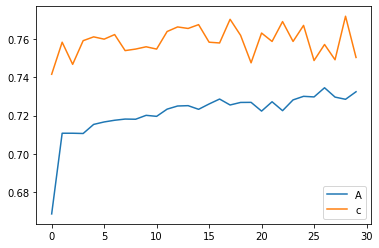

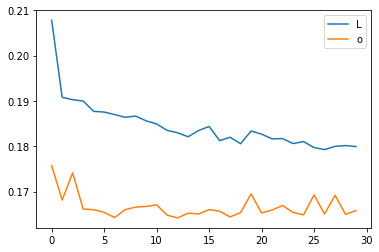

In [60]:
plt.plot(mlp_wv_h.history['accuracy'], label="Training set")
plt.plot(mlp_wv_h.history['val_accuracy'], label="Validation set")
plt.legend("Accuracy")
plt.show()

plt.plot(mlp_wv_h.history['loss'], label="Training set")
plt.plot(mlp_wv_h.history['val_loss'], label="Validation set")
plt.legend("Loss")
plt.show()

In [64]:
loss, acc = mlp_wv.evaluate(X_test_wv, y_test_wv)
# y_pred = model1.predict(X_test_wiki)
print('Test Accuracy: %f' % (acc*100))

782/782 [==============================] - 1s 2ms/step - loss: 0.1635 - accuracy: 0.7610
Test Accuracy: 76.095998


**LSTM model**

In [82]:
def fromTextToFrequenceW2V(corpus, vocab):
  result = []
  for doc in corpus:
    doc_index = []
    for token in doc.split():
      if(token in vocab):
        doc_index.append(vocab[token].index)
    result.append(doc_index)
  return result;

vocab_wv = word_vectors.vocab

X_train_wv_sequences = fromTextToFrequenceW2V(X_train_lstm, vocab_wv)
sequence_len_wv = getMedian(X_train_lstm)
X_train_wv_pad = tf.keras.preprocessing.sequence.pad_sequences(X_train_wv_sequences, maxlen=sequence_len_wv, dtype='int32', padding='pre', truncating='pre',value=0.0)

embeddings_wv = word_vectors.vectors

X_wv_t, X_wv_v, y_wv_t, y_wv_v = train_test_split(X_train_wv_pad,
y_train_lstm, test_size=0.1)

features_wv = 256

lstm_model_wv = tf.keras.Sequential([
    Embedding(len(word_vectors.vectors), features_wv, input_length=sequence_len_wv, embeddings_initializer=tf.keras.initializers.Constant(embeddings_wv), trainable=False),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(LSTM(64, input_shape=(sequence_len_wv, features_wv))),
    tf.keras.layers.Dense(1, activation="sigmoid") 
])

lstm_model_wv.compile( optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

start = time.time()

lstm_model_wv_h = lstm_model_wv.fit(X_wv_t, y_wv_t,
epochs=10,
batch_size=300,
validation_data=(X_wv_v, y_wv_v))

end = time.time() - start
print("- Temps d'entrainement (en secondes): %f\n" % end)

Epoch 1/10
75/75 [==============================] - 15s 199ms/step - loss: 0.5922 - accuracy: 0.6749 - val_loss: 0.5128 - val_accuracy: 0.7696
Epoch 2/10
75/75 [==============================] - 14s 191ms/step - loss: 0.4933 - accuracy: 0.7662 - val_loss: 0.4259 - val_accuracy: 0.8096
Epoch 3/10
75/75 [==============================] - 14s 191ms/step - loss: 0.4487 - accuracy: 0.7931 - val_loss: 0.3958 - val_accuracy: 0.8236
Epoch 4/10
75/75 [==============================] - 14s 190ms/step - loss: 0.4296 - accuracy: 0.8048 - val_loss: 0.3826 - val_accuracy: 0.8336
Epoch 5/10
75/75 [==============================] - 14s 189ms/step - loss: 0.4169 - accuracy: 0.8084 - val_loss: 0.3916 - val_accuracy: 0.8324
Epoch 6/10
75/75 [==============================] - 14s 190ms/step - loss: 0.3971 - accuracy: 0.8220 - val_loss: 0.3640 - val_accuracy: 0.8504
Epoch 7/10
75/75 [==============================] - 14s 191ms/step - loss: 0.3901 - accuracy: 0.8236 - val_loss: 0.3471 - val_accuracy: 0.8480

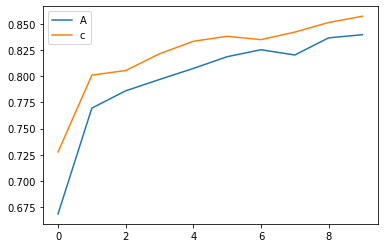

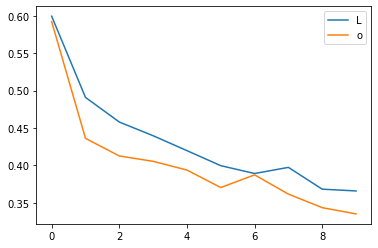

In [67]:
plt.plot(lstm_model_wv_h.history['accuracy'], label="Training set")
plt.plot(lstm_model_wv_h.history['val_accuracy'], label="Validation set")
plt.legend("Accuracy")
plt.show()

plt.plot(lstm_model_wv_h.history['loss'], label="Training set")
plt.plot(lstm_model_wv_h.history['val_loss'], label="Validation set")
plt.legend("Loss")
plt.show()

In [69]:
X_test_wv_sequences = fromTextToFrequenceW2V(X_test_lstm, vocab_wv)
X_test_wv_pad = tf.keras.preprocessing.sequence.pad_sequences(X_test_wv_sequences, maxlen=sequence_len_wv, dtype='int32', padding='pre', truncating='pre',value=0.0)

loss, acc = lstm_model_wv.evaluate(X_test_wv_pad, y_test_lstm)
print('Test Accuracy: %f' % (acc*100))

782/782 [==============================] - 24s 31ms/step - loss: 0.3335 - accuracy: 0.8544
Test Accuracy: 85.439998


## d) Générez une table ou un graphique qui regroupe les performances des modèles, leurs spécifications, la durée d’entraînement et commentez ces résultats. Quelle est l’influence des word embeddings sur les performances?  Quel est votre meilleur modèle ?

| Modele                                               | accuracy | taux de perte Entrainement | Taux de perte Validation | Taux de perte Test | F1 Score | duree d'entrainement (secondes) | Epoch | regularisation | nombre de couches |
|------------------------------------------------------|:--------:|:--------------------------:|:------------------------:|:------------------:|:--------:|:-------------------------------:|:-----:|:--------------:|:-----------------:|
| Gensim Word2Vec                                      |          |                            |                          |          -         |          |            62.765754            |       |                |                   |
| Naive Bayes (sans reduction de dimensions)           | 0.827320 |                            |                          |          -         |   0.83   |              0.0315             |   -   |   alpha = 0.6  |                   |
| Regression logistique (sans reduction de dimensions) |  0.8796  |                            |                          |          -         |   0.88   |              2.024              |   -   |      c = 2     |                   |
| Naive Bayes (avec reduction de dimensions)           |  0.82024 |                            |                          |          -         |   0.82   |              0.0100             |   -   |   alpha = 0.6  |                   |
| Regression logistique (avec reduction de dimensions) | 0.827760 |                            |                          |          -         |   0.83   |              0.302              |   -   |      c = 2     |                   |
| MLP model                                            |  0.8239  |                            |                          |       0.1236       |          |              6.136              |   50  |                |                   |
| LSTM model                                           |  0.8432  |                            |                          |       0.3599       |          |              48.967             |   10  |                |                   |
| MLP model (c)                                        |  0.7610  |                            |                          |       0.1635       |          |              5.516              |   30  |                |                   |
| LSTM model (c)                                       |  0.8544  |                            |                          |       0.3335       |          |             147.628             |   10  |                |                   |